This notebook uses the representations learnt by matrix factorization methods for cell lines and drugs, and uses a downstream classifier to predict the effectiveness of a cell-line - drug interaction in the test split. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
sample_id = 3
repr_folder = f"../../datasets/NCMF/CellLine/"
emb_file = f"emb_sample_{sample_id}.dat" # for NCMF emb
# emb_file = f"cmf_s{sample_id}_CellLine_emb.dat" # for CMF emb
# emb_file = f"gcmf_s{sample_id}_emb_CellLine.dat" # for gCMF emb
# emb_file = f"dfmf_s{sample_id}_emb_CellLine.dat" # for DFMF
# emb_file = f"dcmf_emb_CellLine_sample_{sample_id}.dat" # for DCMF
# repr_folder = f"../../datasets/HNE/CellLine/sample{sample_id}/"
# emb_file = "TransE_emb.dat"

In [3]:
def load(emb_file_path):
    emb_dict = {}
    with open(emb_file_path, 'r') as emb_file:
        for i, line in enumerate(emb_file):
            if i == 0:
                train_para = line[:-1]
            else:
                index, emb = line[:-1].split('\t')
                emb_dict[index] = np.array(emb.split()).astype(np.float32)

    return train_para, emb_dict

In [4]:
train_para, emb_dict = load(repr_folder + emb_file) # indices 0 to 645 form drug embeddings here

In [5]:
len(emb_dict)

1726

In [6]:
emb_shape = emb_dict[list(emb_dict.keys())[0]].shape
print(emb_shape)

(100,)


In [7]:
# ncmf_input_files_path = f"../../datasets/NCMF/CellLine/"
ncmf_input_files_path = f"/home/ajayago/NCMF/bioinf_review/embeddings_CellLines/Set_3/NCMF/"
train_df = pd.read_csv(ncmf_input_files_path + f"sampled{sample_id}_link.dat", sep= "\t", header=None)
train_df.columns = ["left", "right", "link_type", "value"]
train_df

,left,right,link_type,value
0,0,722,0,1.0
1,0,835,0,1.0
2,0,974,0,1.0
3,0,1066,0,1.0
4,0,1068,0,1.0
...,...,...,...,...
656204,690,1673,3,1.0
656205,690,1718,3,1.0
656206,691,1352,3,1.0
656207,691,1389,3,1.0


In [8]:
train_df[train_df["link_type"] == 3]["value"].value_counts()

1.0    3065
Name: value, dtype: int64

In [9]:
entity_df = pd.read_csv(ncmf_input_files_path + "entity_oncokb.csv")
entity_df

,Entity Names
0,ACH-000001
1,ACH-000002
2,ACH-000004
3,ACH-000006
4,ACH-000007
...,...
1721,ZG-10
1722,ZIBOTENTAN
1723,ZM-447439
1724,ZOLEDRONATE


In [10]:
reduced_train_df = train_df[train_df["link_type"] ==3]
reduced_train_df

,left,right,link_type,value
653144,0,1613,3,1.0
653145,0,1665,3,1.0
653146,0,1718,3,1.0
653147,1,1352,3,1.0
653148,1,1439,3,1.0
...,...,...,...,...
656204,690,1673,3,1.0
656205,690,1718,3,1.0
656206,691,1352,3,1.0
656207,691,1389,3,1.0


In [456]:
X0 = np.zeros((692, 638))
X1 = np.zeros((692, 638))
X2 = np.zeros((692, 638))
X3 = np.zeros((692, 396))
for idx, row in train_df[train_df["link_type"] == 0].iterrows():
    left_idx = int(row["left"])
    right_idx = int(row["right"]) - 692
    X0[left_idx][right_idx] = row["value"]
    
for idx, row in train_df[train_df["link_type"] == 1].iterrows():
    left_idx = int(row["left"])
    right_idx = int(row["right"]) - 692
    X1[left_idx][right_idx] = row["value"]
    
for idx, row in train_df[train_df["link_type"] == 2].iterrows():
    left_idx = int(row["left"])
    right_idx = int(row["right"]) - 692
    X2[left_idx][right_idx] = row["value"]
    
for idx, row in train_df[train_df["link_type"] == 3].iterrows():
    left_idx = int(row["left"])
    right_idx = int(row["right"]) - 692 - 638
    X3[left_idx][right_idx] = row["value"]

In [458]:
print("X0 sparsity")
print(100- (np.count_nonzero(X0)*100/(X0.shape[0] * X0.shape[1])))
print("X1 sparsity")
print(100- (np.count_nonzero(X1)*100/(X1.shape[0] * X1.shape[1])))
print("X2 sparsity")
print(100- (np.count_nonzero(X2)*100/(X2.shape[0] * X2.shape[1])))
print("X3 sparsity")
print(100- (np.count_nonzero(X3)*100/(X3.shape[0] * X3.shape[1])))

X0 sparsity
95.4740246797253
X1 sparsity
51.80499936579267
X2 sparsity
4.782149781651469
X3 sparsity
98.88151748700882


In [11]:
X1_train = np.zeros((692, 396))
for idx, row in reduced_train_df.iterrows():
    left_idx = int(row["left"])
    right_idx = int(row["right"]) - 692 - 638
    X1_train[left_idx][right_idx] = 1
X1_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
(X1_train == 1).sum()

3065

In [13]:
reduced_train_df = pd.DataFrame(columns = ["left", "right", "link_type", "value"])
reduced_train_df["left"] = sorted(list(range(0, 692)) * 396)
reduced_train_df["right"] = list(range(692 + 638, 692 + 638 + 396)) * 692
reduced_train_df["link_type"] = 3
reduced_train_df["value"] = X1_train.flatten()
reduced_train_df

,left,right,link_type,value
0,0,1330,3,0.0
1,0,1331,3,0.0
2,0,1332,3,0.0
3,0,1333,3,0.0
4,0,1334,3,0.0
...,...,...,...,...
274027,691,1721,3,0.0
274028,691,1722,3,0.0
274029,691,1723,3,0.0
274030,691,1724,3,0.0


In [14]:
# # add in zeros for training
# x, y = np.where(X1_train == 0)
# for i, j in list(zip(x, y)):
#     reduced_train_df = reduced_train_df.append({"left": i, "right": j + 645, "link_type": 1, "value": 0}, ignore_index=True)

In [15]:
reduced_train_df["value"].value_counts()

0.0    270967
1.0      3065
Name: value, dtype: int64

In [16]:
test_df = pd.read_csv(ncmf_input_files_path + f"sampled{sample_id}_link.dat.test", sep="\t", header=None)
test_df.columns = ["left", "right", "value"]
test_df

,left,right,value
0,598,1375,0
1,454,1371,0
2,248,1572,0
3,0,1651,0
4,468,1508,0
...,...,...,...
54801,321,1700,0
54802,168,1473,1
54803,349,1717,0
54804,3,1445,0


In [17]:
test_df["value"].value_counts()

0    54037
1      769
Name: value, dtype: int64

In [18]:
def get_hadamard_product(row):
    try:
        left_emb = emb_dict[str(int(row["left"]))]
    except:
        left_emb = np.zeros(emb_shape)
    try:
        right_emb = emb_dict[str(int(row["right"]))]
    except:
        right_emb = np.zeros(emb_shape)
    pdt_emb = np.multiply(left_emb, right_emb)
    return pdt_emb

In [19]:
reduced_train_df["emb_hadamard"] = reduced_train_df.apply(lambda row: get_hadamard_product(row), axis = 1)
reduced_train_df

,left,right,link_type,value,emb_hadamard
0,0,1330,3,0.0,"[0.0073313913, 2.7939594e-05, -0.0060492023, -..."
1,0,1331,3,0.0,"[-0.0033882917, 0.00047316248, -0.001136192, -..."
2,0,1332,3,0.0,"[-0.0028762275, 0.00034299947, -0.0012609134, ..."
3,0,1333,3,0.0,"[-0.0028762275, 0.00034299947, -0.0012609134, ..."
4,0,1334,3,0.0,"[-0.006332389, 0.00041895994, 0.0032237563, -0..."
...,...,...,...,...,...
274027,691,1721,3,0.0,"[-0.0030444926, 0.00018435565, -0.001317191, -..."
274028,691,1722,3,0.0,"[-0.0030444926, 0.00018435565, -0.001317191, -..."
274029,691,1723,3,0.0,"[-0.0030444926, 0.00018435565, -0.001317191, -..."
274030,691,1724,3,0.0,"[-0.0030444926, 0.00018435565, -0.001317191, -..."


In [20]:
reduced_train_df.reset_index(drop=True, inplace=True)

In [21]:
test_df["emb_hadamard"] = test_df.apply(lambda row: get_hadamard_product(row), axis = 1)
test_df

,left,right,value,emb_hadamard
0,598,1375,0,"[-0.0027849092, 0.0011409593, 0.0052869404, 0...."
1,454,1371,0,"[-0.0030517518, 0.0003373587, -0.0013322775, -..."
2,248,1572,0,"[-0.005433656, 0.00018138131, -0.0029474774, -..."
3,0,1651,0,"[0.001530722, 0.0004712038, -0.0033989053, -0...."
4,468,1508,0,"[-0.0057968106, 0.00054950145, -0.0026005546, ..."
...,...,...,...,...
54801,321,1700,0,"[-0.0029067157, 0.00013641686, -0.0012378924, ..."
54802,168,1473,1,"[-0.002787305, 0.00067797623, -0.0012983582, -..."
54803,349,1717,0,"[-0.0029471682, 0.00021495181, -0.001306168, -..."
54804,3,1445,0,"[0.00069858774, 0.0006128736, -0.0054985904, -..."


In [22]:
test_df["value"]

0        0
1        0
2        0
3        0
4        0
        ..
54801    0
54802    1
54803    0
54804    0
54805    0
Name: value, Length: 54806, dtype: int64

In [23]:
test_df.reset_index(inplace=True, drop=True)

In [24]:
reduced_train_df["emb_hadamard"].values[0].shape

(100,)

In [25]:
reduced_train_df[[f"emb_{i}" for i in range(0, reduced_train_df["emb_hadamard"].values[0].shape[0])]] = pd.DataFrame(reduced_train_df.emb_hadamard.tolist(), index= reduced_train_df.index)
reduced_train_df

,left,right,link_type,value,emb_hadamard,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99
0,0,1330,3,0.0,"[0.0073313913, 2.7939594e-05, -0.0060492023, -...",0.007331,0.000028,-0.006049,-0.002450,0.000795,...,-0.002526,0.005935,-0.002601,0.011305,-0.014510,-0.001473,-0.001633,0.001984,0.000503,0.005313
1,0,1331,3,0.0,"[-0.0033882917, 0.00047316248, -0.001136192, -...",-0.003388,0.000473,-0.001136,-0.002257,-0.003354,...,-0.001783,-0.002607,0.005506,-0.003551,-0.000094,-0.002290,0.000459,-0.002724,0.003049,-0.006490
2,0,1332,3,0.0,"[-0.0028762275, 0.00034299947, -0.0012609134, ...",-0.002876,0.000343,-0.001261,-0.001956,-0.004244,...,0.000336,-0.003522,0.003350,-0.004638,-0.002507,0.000509,-0.003246,-0.002587,0.002316,-0.003430
3,0,1333,3,0.0,"[-0.0028762275, 0.00034299947, -0.0012609134, ...",-0.002876,0.000343,-0.001261,-0.001956,-0.004244,...,0.000336,-0.003522,0.003350,-0.004638,-0.002507,0.000509,-0.003246,-0.002587,0.002316,-0.003430
4,0,1334,3,0.0,"[-0.006332389, 0.00041895994, 0.0032237563, -0...",-0.006332,0.000419,0.003224,-0.003891,-0.008979,...,0.000942,-0.004390,0.005724,0.001726,-0.001584,-0.001059,-0.003923,-0.005687,0.002656,-0.003187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274027,691,1721,3,0.0,"[-0.0030444926, 0.00018435565, -0.001317191, -...",-0.003044,0.000184,-0.001317,-0.002142,-0.004472,...,0.000355,-0.003579,0.003714,-0.004958,-0.002720,0.000518,-0.003732,-0.002670,0.002623,-0.003556
274028,691,1722,3,0.0,"[-0.0030444926, 0.00018435565, -0.001317191, -...",-0.003044,0.000184,-0.001317,-0.002142,-0.004472,...,0.000355,-0.003579,0.003714,-0.004958,-0.002720,0.000518,-0.003732,-0.002670,0.002623,-0.003556
274029,691,1723,3,0.0,"[-0.0030444926, 0.00018435565, -0.001317191, -...",-0.003044,0.000184,-0.001317,-0.002142,-0.004472,...,0.000355,-0.003579,0.003714,-0.004958,-0.002720,0.000518,-0.003732,-0.002670,0.002623,-0.003556
274030,691,1724,3,0.0,"[-0.0030444926, 0.00018435565, -0.001317191, -...",-0.003044,0.000184,-0.001317,-0.002142,-0.004472,...,0.000355,-0.003579,0.003714,-0.004958,-0.002720,0.000518,-0.003732,-0.002670,0.002623,-0.003556


In [26]:
test_df[[f"emb_{i}" for i in range(0, reduced_train_df["emb_hadamard"].values[0].shape[0])]] = pd.DataFrame(test_df.emb_hadamard.tolist(), index= test_df.index)
test_df

,left,right,value,emb_hadamard,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,...,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99
0,598,1375,0,"[-0.0027849092, 0.0011409593, 0.0052869404, 0....",-0.002785,0.001141,0.005287,0.002193,-0.007741,-0.000056,...,-0.006786,0.002349,0.000951,0.003267,0.000524,0.004027,0.005932,-0.001307,-0.001740,-0.008788
1,454,1371,0,"[-0.0030517518, 0.0003373587, -0.0013322775, -...",-0.003052,0.000337,-0.001332,-0.002138,-0.004431,0.000230,...,0.000347,-0.003522,0.003498,-0.004974,-0.002654,0.000531,-0.003694,-0.002638,0.002408,-0.003550
2,248,1572,0,"[-0.005433656, 0.00018138131, -0.0029474774, -...",-0.005434,0.000181,-0.002947,-0.003009,-0.004303,0.000167,...,-0.001589,0.000120,0.003595,-0.004901,-0.002079,0.001912,-0.003414,-0.004878,0.002986,-0.001561
3,0,1651,0,"[0.001530722, 0.0004712038, -0.0033989053, -0....",0.001531,0.000471,-0.003399,-0.000554,-0.007307,-0.000005,...,-0.000464,-0.002901,0.002856,-0.001851,0.000369,0.002427,0.000025,-0.002314,0.002268,-0.000385
4,468,1508,0,"[-0.0057968106, 0.00054950145, -0.0026005546, ...",-0.005797,0.000550,-0.002601,-0.005121,-0.006530,0.000131,...,-0.000369,-0.005399,0.004815,-0.005475,-0.001797,0.002920,-0.003430,-0.003705,0.002384,-0.002259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54801,321,1700,0,"[-0.0029067157, 0.00013641686, -0.0012378924, ...",-0.002907,0.000136,-0.001238,-0.002060,-0.004342,0.000327,...,0.000344,-0.003507,0.003626,-0.004772,-0.002456,0.000485,-0.003535,-0.002530,0.002368,-0.003498
54802,168,1473,1,"[-0.002787305, 0.00067797623, -0.0012983582, -...",-0.002787,0.000678,-0.001298,-0.002032,-0.004274,0.000287,...,0.000345,-0.003440,0.003190,-0.004677,-0.002564,0.000508,-0.003569,-0.002422,0.002154,-0.003516
54803,349,1717,0,"[-0.0029471682, 0.00021495181, -0.001306168, -...",-0.002947,0.000215,-0.001306,-0.002129,-0.004439,0.000212,...,0.000348,-0.003574,0.003562,-0.004786,-0.002492,0.000511,-0.003650,-0.002503,0.002384,-0.003408
54804,3,1445,0,"[0.00069858774, 0.0006128736, -0.0054985904, -...",0.000699,0.000613,-0.005499,-0.003652,-0.001325,0.000432,...,-0.009065,0.002083,-0.000950,-0.001746,0.000041,-0.004358,-0.004707,0.004726,0.003157,-0.010765


In [27]:
test_df["tuple"] = test_df.apply(lambda x: (x["left"], x["right"]), axis = 1)

In [28]:
reduced_train_df["tuple"] = reduced_train_df.apply(lambda x: (x["left"], x["right"]), axis = 1)

In [29]:
reduced_train_df_new = reduced_train_df[reduced_train_df["tuple"].isin(set(reduced_train_df["tuple"]) - set(test_df["tuple"]))]

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42, max_depth=50)
rf.fit(reduced_train_df_new[[f"emb_{i}" for i in range(0, reduced_train_df["emb_hadamard"].values[0].shape[0])]].values, reduced_train_df_new["value"].values)

RandomForestClassifier(max_depth=50, random_state=42)

In [31]:
preds_prob_rf = rf.predict_proba(test_df[[f"emb_{i}" for i in range(0, reduced_train_df["emb_hadamard"].values[0].shape[0])]].values)
y_true = test_df["value"].values

In [32]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
auroc = roc_auc_score(y_true, preds_prob_rf[:, 1])
precision, recall, thresholds = precision_recall_curve(y_true, preds_prob_rf[:, 1])
auprc = auc(recall, precision)
print('Random forest')
print(f"AUROC = {auroc}")
print(f"AUPRC = {auprc}")

Random forest
AUROC = 0.9577758970861678
AUPRC = 0.4296069145061285


In [33]:
preds = rf.predict(test_df[[f"emb_{i}" for i in range(0, reduced_train_df["emb_hadamard"].values[0].shape[0])]].values)

In [34]:
np.count_nonzero(preds)

265

In [35]:
np.count_nonzero(y_true)

769

In [36]:
test_df["preds"] = preds

In [301]:
test_df["preds_prob"] = preds_prob_rf[:, 1]

#### Case Study

In [302]:
test_df_reduced = test_df[["left", "right", "value", "preds", "preds_prob"]].merge(entity_df.reset_index(), left_on="left", right_on='index').drop("index", axis = 1)
test_df_reduced.rename(columns={"Entity Names": "DepMap_ID"}, inplace=True)
test_df_reduced

,left,right,value,preds,preds_prob,DepMap_ID
0,598,1375,0,0.0,0.170909,ACH-000960
1,598,1377,0,0.0,0.000000,ACH-000960
2,598,1501,0,0.0,0.090014,ACH-000960
3,598,1724,0,0.0,0.000000,ACH-000960
4,598,1438,0,0.0,0.140099,ACH-000960
...,...,...,...,...,...,...
54801,540,1337,0,0.0,0.000000,ACH-000876
54802,540,1408,0,0.0,0.000000,ACH-000876
54803,540,1362,0,0.0,0.000000,ACH-000876
54804,540,1332,0,0.0,0.000000,ACH-000876


In [303]:
test_df_reduced = test_df_reduced.merge(entity_df.reset_index(), left_on="right", right_on='index').drop("index", axis = 1)
test_df_reduced.rename(columns={"Entity Names": "drug"}, inplace=True)
test_df_reduced

,left,right,value,preds,preds_prob,DepMap_ID,drug
0,598,1375,0,0.0,0.170909,ACH-000960,AZD7762
1,579,1375,0,0.0,0.000148,ACH-000935,AZD7762
2,669,1375,0,0.0,0.000138,ACH-001530,AZD7762
3,266,1375,0,0.0,0.000135,ACH-000441,AZD7762
4,279,1375,0,0.0,0.000154,ACH-000465,AZD7762
...,...,...,...,...,...,...,...
54801,630,1451,0,0.0,0.000000,ACH-001190,EPZ-5676
54802,220,1451,0,0.0,0.000000,ACH-000372,EPZ-5676
54803,221,1451,0,0.0,0.000000,ACH-000373,EPZ-5676
54804,241,1451,0,0.0,0.000000,ACH-000403,EPZ-5676


In [304]:
reduced_train_df_new_reduced = reduced_train_df_new[["left", "right", "value"]].merge(entity_df.reset_index(), left_on="left", right_on='index').drop("index", axis = 1)
reduced_train_df_new_reduced.rename(columns={"Entity Names": "DepMap_ID"}, inplace=True)
reduced_train_df_new_reduced

,left,right,value,DepMap_ID
0,0,1330,0.0,ACH-000001
1,0,1331,0.0,ACH-000001
2,0,1332,0.0,ACH-000001
3,0,1333,0.0,ACH-000001
4,0,1335,0.0,ACH-000001
...,...,...,...,...
219221,691,1719,0.0,ACH-001716
219222,691,1720,0.0,ACH-001716
219223,691,1721,0.0,ACH-001716
219224,691,1722,0.0,ACH-001716


In [305]:
reduced_train_df_new_reduced = reduced_train_df_new_reduced.merge(entity_df.reset_index(), left_on="right", right_on='index').drop("index", axis = 1)
reduced_train_df_new_reduced.rename(columns={"Entity Names": "drugs"}, inplace=True)
reduced_train_df_new_reduced

,left,right,value,DepMap_ID,drugs
0,0,1330,0.0,ACH-000001,(5Z)-7-OXOZEAENOL
1,1,1330,0.0,ACH-000002,(5Z)-7-OXOZEAENOL
2,2,1330,0.0,ACH-000004,(5Z)-7-OXOZEAENOL
3,3,1330,1.0,ACH-000006,(5Z)-7-OXOZEAENOL
4,4,1330,0.0,ACH-000007,(5Z)-7-OXOZEAENOL
...,...,...,...,...,...
219221,686,1592,0.0,ACH-001674,PELITINIB
219222,688,1592,0.0,ACH-001703,PELITINIB
219223,689,1592,0.0,ACH-001711,PELITINIB
219224,690,1592,0.0,ACH-001715,PELITINIB


In [306]:
# true positives and true negatives
good_preds = test_df_reduced[test_df_reduced["preds"] == test_df_reduced["value"]]
bad_preds = test_df_reduced[test_df_reduced["preds"] != test_df_reduced["value"]]

#### Cell line analysis

In [307]:
# cell lines in train and test
reduced_train_df_new_reduced["DepMap_ID"].value_counts()

ACH-001625    339
ACH-000115    338
ACH-000136    338
ACH-001498    335
ACH-000744    334
             ... 
ACH-000609    298
ACH-000432    296
ACH-000644    296
ACH-000751    294
ACH-000561    292
Name: DepMap_ID, Length: 692, dtype: int64

In [308]:
train_cl_counts = pd.DataFrame(reduced_train_df_new_reduced["DepMap_ID"].value_counts()).reset_index()
train_cl_counts.columns = ['DepMap_ID', 'count']
train_cl_counts

,DepMap_ID,count
0,ACH-001625,339
1,ACH-000115,338
2,ACH-000136,338
3,ACH-001498,335
4,ACH-000744,334
...,...,...
687,ACH-000609,298
688,ACH-000432,296
689,ACH-000644,296
690,ACH-000751,294


In [309]:
good_cl_counts = pd.DataFrame(good_preds["DepMap_ID"].value_counts()).reset_index()
good_cl_counts.columns = ['DepMap_ID', 'count']
good_cl_counts

,DepMap_ID,count
0,ACH-000561,103
1,ACH-000751,100
2,ACH-000644,100
3,ACH-000469,98
4,ACH-000860,98
...,...,...
687,ACH-001498,60
688,ACH-000744,60
689,ACH-000115,58
690,ACH-000136,57


In [310]:
bad_cl_counts = pd.DataFrame(bad_preds["DepMap_ID"].value_counts()).reset_index()
bad_cl_counts.columns = ["DepMap_ID", "count"]
bad_cl_counts

,DepMap_ID,count
0,ACH-000198,9
1,ACH-000112,8
2,ACH-000045,8
3,ACH-000287,8
4,ACH-000233,6
...,...,...
372,ACH-000452,1
373,ACH-000414,1
374,ACH-000009,1
375,ACH-000456,1


In [311]:
merged_cl = pd.merge(train_cl_counts, good_cl_counts, left_on = "DepMap_ID", right_on = "DepMap_ID", suffixes=("_train", "_good_test"), how="outer").merge(bad_cl_counts, on='DepMap_ID', how="outer").sort_values(by="count_train", ascending=False)
merged_cl

,DepMap_ID,count_train,count_good_test,count
0,ACH-001625,339,56,1.0
2,ACH-000136,338,57,1.0
1,ACH-000115,338,58,NaN
3,ACH-001498,335,60,1.0
4,ACH-000744,334,60,2.0
...,...,...,...,...
687,ACH-000609,298,96,2.0
688,ACH-000432,296,96,4.0
689,ACH-000644,296,100,NaN
690,ACH-000751,294,100,2.0


In [312]:
merged_cl.rename(columns={"count": "count_bad_test"}, inplace=True)

In [313]:
merged_cl.fillna(0, inplace=True)

In [314]:
merged_cl

,DepMap_ID,count_train,count_good_test,count_bad_test
0,ACH-001625,339,56,1.0
2,ACH-000136,338,57,1.0
1,ACH-000115,338,58,0.0
3,ACH-001498,335,60,1.0
4,ACH-000744,334,60,2.0
...,...,...,...,...
687,ACH-000609,298,96,2.0
688,ACH-000432,296,96,4.0
689,ACH-000644,296,100,0.0
690,ACH-000751,294,100,2.0


In [315]:
merged_cl["pct_good"] = merged_cl["count_good_test"] / (merged_cl["count_good_test"] + merged_cl["count_bad_test"])
merged_cl["pct_bad"] = merged_cl["count_bad_test"] / (merged_cl["count_good_test"] + merged_cl["count_bad_test"])
merged_cl

,DepMap_ID,count_train,count_good_test,count_bad_test,pct_good,pct_bad
0,ACH-001625,339,56,1.0,0.982456,0.017544
2,ACH-000136,338,57,1.0,0.982759,0.017241
1,ACH-000115,338,58,0.0,1.000000,0.000000
3,ACH-001498,335,60,1.0,0.983607,0.016393
4,ACH-000744,334,60,2.0,0.967742,0.032258
...,...,...,...,...,...,...
687,ACH-000609,298,96,2.0,0.979592,0.020408
688,ACH-000432,296,96,4.0,0.960000,0.040000
689,ACH-000644,296,100,0.0,1.000000,0.000000
690,ACH-000751,294,100,2.0,0.980392,0.019608


In [316]:
(merged_cl["count_train"] + merged_cl["count_good_test"] + merged_cl["count_bad_test"]).sort_values()

0      396.0
477    396.0
478    396.0
479    396.0
486    396.0
       ...  
248    396.0
249    396.0
250    396.0
208    396.0
691    396.0
Length: 692, dtype: float64

In [317]:
merged_cl_mean = merged_cl.groupby("count_train").agg("mean").reset_index()
merged_cl_mean

,count_train,count_good_test,count_bad_test,pct_good,pct_bad
0,292,103.000000,1.000000,0.990385,0.009615
1,294,100.000000,2.000000,0.980392,0.019608
2,296,98.000000,2.000000,0.980000,0.020000
3,298,97.000000,1.000000,0.989796,0.010204
4,299,95.250000,1.750000,0.981959,0.018041
5,300,95.250000,0.750000,0.992188,0.007812
6,301,93.333333,1.666667,0.982456,0.017544
7,302,93.285714,0.714286,0.992401,0.007599
8,303,92.250000,0.750000,0.991935,0.008065
9,304,90.800000,1.200000,0.986957,0.013043


In [318]:
import seaborn as sns

#### Drugs Analysis

In [327]:
train_drug_counts = pd.DataFrame(reduced_train_df_new_reduced["drugs"].value_counts()).reset_index()
train_drug_counts.columns = ['drugs', 'count']
train_drug_counts

,drugs,count
0,VOXTALISIB,583
1,SB 505124,583
2,EPZ004777,582
3,GW843682X,582
4,EX-527,580
...,...,...
391,GNF-2,526
392,YM-155,526
393,XAV-939,525
394,ERLOTINIB,522


In [328]:
good_drug_counts = pd.DataFrame(good_preds["drug"].value_counts()).reset_index()
good_drug_counts.columns = ['drugs', 'count']
good_drug_counts

,drugs,count
0,ERLOTINIB,170
1,XAV-939,167
2,JW-7-52-1,166
3,GNF-2,166
4,QL-XII-47,165
...,...,...
391,PANOBINOSTAT,108
392,THAPSIGARGIN,102
393,YM-155,101
394,MITOMYCIN-C,99


In [329]:
bad_drug_counts = pd.DataFrame(bad_preds["drug"].value_counts()).reset_index()
bad_drug_counts.columns = ["drugs", "count"]
bad_drug_counts

,drugs,count
0,YM-155,65
1,TORIN-2,46
2,THAPSIGARGIN,39
3,MITOMYCIN-C,37
4,DOCETAXEL,33
...,...,...
100,SUNITINIB,1
101,ZSTK-474,1
102,BX-795,1
103,IDELALISIB,1


In [330]:
merged_drug = pd.merge(train_drug_counts, good_drug_counts, left_on = "drugs", right_on = "drugs", suffixes=("_train", "_good_test"), how="outer").merge(bad_drug_counts, on='drugs', how="outer").sort_values(by="count_train", ascending=False)
merged_drug

,drugs,count_train,count_good_test,count
0,VOXTALISIB,583,109,NaN
1,SB 505124,583,109,NaN
2,EPZ004777,582,110,NaN
3,GW843682X,582,110,NaN
4,EX-527,580,112,NaN
...,...,...,...,...
391,GNF-2,526,166,NaN
392,YM-155,526,101,65.0
393,XAV-939,525,167,NaN
394,ERLOTINIB,522,170,NaN


In [331]:
merged_drug.rename(columns={"count": "count_bad_test"}, inplace=True)

In [332]:
merged_drug.fillna(0, inplace=True)

In [333]:
merged_drug

,drugs,count_train,count_good_test,count_bad_test
0,VOXTALISIB,583,109,0.0
1,SB 505124,583,109,0.0
2,EPZ004777,582,110,0.0
3,GW843682X,582,110,0.0
4,EX-527,580,112,0.0
...,...,...,...,...
391,GNF-2,526,166,0.0
392,YM-155,526,101,65.0
393,XAV-939,525,167,0.0
394,ERLOTINIB,522,170,0.0


In [334]:
merged_drug["pct_good"] = merged_drug["count_good_test"] / (merged_drug["count_good_test"] + merged_drug["count_bad_test"])
merged_drug["pct_bad"] = merged_drug["count_bad_test"] / (merged_drug["count_good_test"] + merged_drug["count_bad_test"])
merged_drug

,drugs,count_train,count_good_test,count_bad_test,pct_good,pct_bad
0,VOXTALISIB,583,109,0.0,1.000000,0.000000
1,SB 505124,583,109,0.0,1.000000,0.000000
2,EPZ004777,582,110,0.0,1.000000,0.000000
3,GW843682X,582,110,0.0,1.000000,0.000000
4,EX-527,580,112,0.0,1.000000,0.000000
...,...,...,...,...,...,...
391,GNF-2,526,166,0.0,1.000000,0.000000
392,YM-155,526,101,65.0,0.608434,0.391566
393,XAV-939,525,167,0.0,1.000000,0.000000
394,ERLOTINIB,522,170,0.0,1.000000,0.000000


In [335]:
merged_drug.sort_values(by="pct_good", ascending=False)

,drugs,count_train,count_good_test,count_bad_test,pct_good,pct_bad
0,VOXTALISIB,583,109,0.0,1.000000,0.000000
256,BORTEZOMIB,550,142,0.0,1.000000,0.000000
254,PIPERLONGUMINE,550,142,0.0,1.000000,0.000000
255,QS11,550,142,0.0,1.000000,0.000000
233,OXALIPLATIN,551,141,0.0,1.000000,0.000000
...,...,...,...,...,...,...
338,DOCETAXEL,541,118,33.0,0.781457,0.218543
172,MITOMYCIN-C,556,99,37.0,0.727941,0.272059
232,THAPSIGARGIN,551,102,39.0,0.723404,0.276596
242,TORIN-2,551,95,46.0,0.673759,0.326241


In [336]:
(merged_drug["count_train"] + merged_drug["count_good_test"] + merged_drug["count_bad_test"]).sort_values()

0      692.0
282    692.0
276    692.0
257    692.0
258    692.0
       ...  
125    692.0
129    692.0
127    692.0
130    692.0
395    692.0
Length: 396, dtype: float64

#### Cell line Metadata

In [341]:
cl_metadata = pd.read_csv("../../datasets/NCMF/CellLine/cell_lines_metadata.csv")
cl_metadata = cl_metadata[cl_metadata["DepMap_ID"].isin(entity_df["Entity Names"])]
cl_metadata

,DepMap_ID,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
44,ACH-000288,BT-549,BT549,BT549_BREAST,NaN,905951.0,Female,ATCC,CVCL_1092,1835.0,...,ERneg_HER2neg,basal_B,2D: adherent,NaN,NaN,PT-hgWgpg,NaN,Invasive breast carcinoma of no special type,C4194,NaN
400,ACH-000001,NIH:OVCAR-3,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,Female,ATCC,CVCL_0465,2201.0,...,high_grade_serous,NaN,2D: adherent,NaN,NaN,PT-gj46wT,NaN,High grade ovarian serous adenocarcinoma,C105555,NaN
401,ACH-000002,HL-60,HL60,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,905938.0,Female,ATCC,CVCL_0002,55.0,...,M3,NaN,2D: suspension,NaN,NaN,PT-5qa3uk,NaN,Adult acute myeloid leukemia,C9154,NaN
403,ACH-000004,HEL,HEL,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,907053.0,Male,DSMZ,CVCL_0001,783.0,...,M6,NaN,2D: suspension,NaN,NaN,PT-q4K2cp,NaN,Erythroleukemia,C7152,NaN
405,ACH-000006,MONO-MAC-6,MONOMAC6,MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,908148.0,Male,DSMZ,CVCL_1426,2167.0,...,M5,NaN,2D: adherent,NaN,NaN,PT-ej13Dz,NaN,Adult acute monocytic leukemia,C8263,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,ACH-001702,VA-ES-BJ,VAESBJ,VAESBJ_SOFT_TISSUE,NaN,688121.0,Male,ATCC,CVCL_1785,1004.0,...,NaN,NaN,2D: adherent,NaN,NaN,PT-vslXtO,NaN,Epithelioid sarcoma,C3714,NaN
1542,ACH-001703,VAL,VAL,VAL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,1331048.0,Female,DSMZ,CVCL_1819,2221.0,...,DLBCL,NaN,2D: suspension,NaN,NaN,PT-jXERAO,NaN,Diffuse large B-cell lymphoma,C8851,NaN
1545,ACH-001711,PFSK-1,PFSK1,PFSK1_CENTRAL_NERVOUS_SYSTEM,NaN,683667.0,Male,ATCC,CVCL_1642,1682.0,...,NaN,NaN,2D: adherent,NaN,NaN,PT-lzKK9W,NaN,Primitive neuroectodermal tumor,C3716,NaN
1546,ACH-001715,CAL-72,CAL72,CAL72_BONE,NaN,906827.0,Male,DSMZ,CVCL_1113,550.0,...,NaN,NaN,2D: adherent,NaN,NaN,PT-fcGStb,NaN,Osteosarcoma,C9145,NaN


In [342]:
reduced_train_df_new_reduced_metadata = reduced_train_df_new_reduced.merge(cl_metadata, on = "DepMap_ID")
reduced_train_df_new_reduced_metadata

,left,right,value,DepMap_ID,drugs,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
0,0,1330,0.0,ACH-000001,(5Z)-7-OXOZEAENOL,NIH:OVCAR-3,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,...,high_grade_serous,NaN,2D: adherent,NaN,NaN,PT-gj46wT,NaN,High grade ovarian serous adenocarcinoma,C105555,NaN
1,0,1331,0.0,ACH-000001,5-FLUOROURACIL,NIH:OVCAR-3,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,...,high_grade_serous,NaN,2D: adherent,NaN,NaN,PT-gj46wT,NaN,High grade ovarian serous adenocarcinoma,C105555,NaN
2,0,1332,0.0,ACH-000001,681640,NIH:OVCAR-3,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,...,high_grade_serous,NaN,2D: adherent,NaN,NaN,PT-gj46wT,NaN,High grade ovarian serous adenocarcinoma,C105555,NaN
3,0,1333,0.0,ACH-000001,A-443654,NIH:OVCAR-3,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,...,high_grade_serous,NaN,2D: adherent,NaN,NaN,PT-gj46wT,NaN,High grade ovarian serous adenocarcinoma,C105555,NaN
4,0,1335,0.0,ACH-000001,A-83-01,NIH:OVCAR-3,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,...,high_grade_serous,NaN,2D: adherent,NaN,NaN,PT-gj46wT,NaN,High grade ovarian serous adenocarcinoma,C105555,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219221,226,1625,0.0,ACH-000379,RU-SKI-43,NCI-H1781,NCIH1781,NCIH1781_LUNG,NaN,1298350.0,...,NSCLC_adenocarcinoma,NaN,2D: adherent,NaN,NaN,PT-ZMox9l,NaN,Minimally invasive lung adenocarcinoma,C2923,NaN
219222,226,1634,0.0,ACH-000379,SB-216763,NCI-H1781,NCIH1781,NCIH1781_LUNG,NaN,1298350.0,...,NSCLC_adenocarcinoma,NaN,2D: adherent,NaN,NaN,PT-ZMox9l,NaN,Minimally invasive lung adenocarcinoma,C2923,NaN
219223,226,1706,0.0,ACH-000379,WYE-125132,NCI-H1781,NCIH1781,NCIH1781_LUNG,NaN,1298350.0,...,NSCLC_adenocarcinoma,NaN,2D: adherent,NaN,NaN,PT-ZMox9l,NaN,Minimally invasive lung adenocarcinoma,C2923,NaN
219224,226,1716,0.0,ACH-000379,Y-39983,NCI-H1781,NCIH1781,NCIH1781_LUNG,NaN,1298350.0,...,NSCLC_adenocarcinoma,NaN,2D: adherent,NaN,NaN,PT-ZMox9l,NaN,Minimally invasive lung adenocarcinoma,C2923,NaN


In [343]:
reduced_train_df_new_reduced_metadata.primary_or_metastasis.value_counts()

Primary       112028
Metastasis     77885
Name: primary_or_metastasis, dtype: int64

In [344]:
good_preds_metadata = good_preds.merge(cl_metadata, on="DepMap_ID")
good_preds_metadata

,left,right,value,preds,preds_prob,DepMap_ID,drug,cell_line_name,stripped_cell_line_name,CCLE_Name,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
0,598,1375,0,0.0,0.170909,ACH-000960,AZD7762,Reh,REH,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,b_cell,NaN,2D: suspension,NaN,NaN,PT-N5YXV2,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
1,598,1377,0,0.0,0.000000,ACH-000960,AZD8186,Reh,REH,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,b_cell,NaN,2D: suspension,NaN,NaN,PT-N5YXV2,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
2,598,1501,0,0.0,0.090014,ACH-000960,IKK-2-INHIBITOR-V,Reh,REH,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,b_cell,NaN,2D: suspension,NaN,NaN,PT-N5YXV2,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
3,598,1724,0,0.0,0.000000,ACH-000960,ZOLEDRONATE,Reh,REH,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,b_cell,NaN,2D: suspension,NaN,NaN,PT-N5YXV2,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
4,598,1438,0,0.0,0.140099,ACH-000960,DMOG,Reh,REH,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,b_cell,NaN,2D: suspension,NaN,NaN,PT-N5YXV2,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54121,140,1539,0,0.0,0.000000,ACH-000247,LJI308,OCUM-1,OCUM1,OCUM1_STOMACH,...,diffuse_gastric,NaN,NaN,NaN,NaN,PT-JKf5mS,NaN,Gastric signet ring cell adenocarcinoma,C5250,NaN
54122,140,1427,0,0.0,0.000000,ACH-000247,CYCLOPAMINE,OCUM-1,OCUM1,OCUM1_STOMACH,...,diffuse_gastric,NaN,NaN,NaN,NaN,PT-JKf5mS,NaN,Gastric signet ring cell adenocarcinoma,C5250,NaN
54123,140,1599,0,0.0,0.000000,ACH-000247,PHA-665752,OCUM-1,OCUM1,OCUM1_STOMACH,...,diffuse_gastric,NaN,NaN,NaN,NaN,PT-JKf5mS,NaN,Gastric signet ring cell adenocarcinoma,C5250,NaN
54124,140,1535,0,0.0,0.000000,ACH-000247,LGK-974,OCUM-1,OCUM1,OCUM1_STOMACH,...,diffuse_gastric,NaN,NaN,NaN,NaN,PT-JKf5mS,NaN,Gastric signet ring cell adenocarcinoma,C5250,NaN


In [345]:
good_preds_metadata.primary_or_metastasis.value_counts()

Primary       27813
Metastasis    18961
Name: primary_or_metastasis, dtype: int64

In [346]:
good_preds_metadata.sex.value_counts()

Male      28980
Female    24096
Name: sex, dtype: int64

In [347]:
bad_preds_metadata = bad_preds.merge(cl_metadata, on="DepMap_ID")
bad_preds_metadata

,left,right,value,preds,preds_prob,DepMap_ID,drug,cell_line_name,stripped_cell_line_name,CCLE_Name,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
0,150,1375,1,0.0,0.000138,ACH-000263,AZD7762,KASUMI-1,KASUMI1,KASUMI1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,M2,NaN,NaN,NaN,NaN,PT-uzWVHa,NaN,Childhood acute myeloid leukemia with maturation,C9381,NaN
1,150,1673,0,1.0,0.510000,ACH-000263,TORIN-2,KASUMI-1,KASUMI1,KASUMI1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,M2,NaN,NaN,NaN,NaN,PT-uzWVHa,NaN,Childhood acute myeloid leukemia with maturation,C9381,NaN
2,150,1576,1,0.0,0.070000,ACH-000263,OSI-027,KASUMI-1,KASUMI1,KASUMI1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,M2,NaN,NaN,NaN,NaN,PT-uzWVHa,NaN,Childhood acute myeloid leukemia with maturation,C9381,NaN
3,150,1541,1,0.0,0.000159,ACH-000263,MASITINIB,KASUMI-1,KASUMI1,KASUMI1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,M2,NaN,NaN,NaN,NaN,PT-uzWVHa,NaN,Childhood acute myeloid leukemia with maturation,C9381,NaN
4,150,1619,1,0.0,0.010003,ACH-000263,QUIZARTINIB,KASUMI-1,KASUMI1,KASUMI1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,M2,NaN,NaN,NaN,NaN,PT-uzWVHa,NaN,Childhood acute myeloid leukemia with maturation,C9381,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,686,1558,1,0.0,0.000237,ACH-001674,NAVITOCLAX,TGW,TGW,TGW_AUTONOMIC_GANGLIA,...,NaN,NaN,2D: adherent,NaN,NaN,PT-o4jARg,NaN,Adrenal gland neuroblastoma,C4827,NaN
676,192,1484,1,0.0,0.010006,ACH-000338,GSK269962A,SR-786,SR786,SR786_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,t_cell_ALCL,NaN,NaN,NaN,NaN,PT-khOMVk,NaN,"Anaplastic large cell lymphoma, ALK-positive",C37193,Removed from DepMap;
677,416,1359,1,0.0,0.000195,ACH-000679,AST-1306,OE-19,OE19,OE19_OESOPHAGUS,...,laryngeal,NaN,NaN,NaN,NaN,PT-Tt2TJf,NaN,Esophageal adenocarcinoma,C4025,NaN
678,416,1433,1,0.0,0.000372,ACH-000679,DACOMITINIB,OE-19,OE19,OE19_OESOPHAGUS,...,laryngeal,NaN,NaN,NaN,NaN,PT-Tt2TJf,NaN,Esophageal adenocarcinoma,C4025,NaN


In [348]:
bad_preds_metadata.sex.value_counts()

Male      390
Female    283
Name: sex, dtype: int64

In [349]:
bad_preds_metadata.primary_or_metastasis.value_counts()

Primary       343
Metastasis    174
Name: primary_or_metastasis, dtype: int64

In [350]:
disease_train = pd.DataFrame(reduced_train_df_new_reduced_metadata["primary_disease"].value_counts()).reset_index()
disease_train.columns = ["disease", "count"]
disease_train

,disease,count
0,Lung Cancer,44053
1,Leukemia,16744
2,Breast Cancer,14244
3,Lymphoma,13705
4,Colon/Colorectal Cancer,13527
5,Brain Cancer,12305
6,Skin Cancer,11447
7,Ovarian Cancer,10784
8,Esophageal Cancer,9167
9,Pancreatic Cancer,8875


In [351]:
disease_test_good = pd.DataFrame(good_preds_metadata["primary_disease"].value_counts()).reset_index()
disease_test_good.columns = ["disease", "count"]
disease_test_good

,disease,count
0,Lung Cancer,10921
1,Leukemia,4100
2,Breast Cancer,3531
3,Colon/Colorectal Cancer,3476
4,Lymphoma,3245
5,Brain Cancer,3113
6,Skin Cancer,2767
7,Ovarian Cancer,2663
8,Esophageal Cancer,2294
9,Pancreatic Cancer,2204


In [352]:
disease_test_bad = pd.DataFrame(bad_preds_metadata["primary_disease"].value_counts()).reset_index()
disease_test_bad.columns = ["disease", "count"]
disease_test_bad

,disease,count
0,Leukemia,144
1,Lymphoma,78
2,Lung Cancer,70
3,Breast Cancer,45
4,Skin Cancer,42
5,Brain Cancer,26
6,Colon/Colorectal Cancer,25
7,Esophageal Cancer,23
8,Liver Cancer,23
9,Myeloma,23


In [353]:
disease_merged = disease_train.merge(disease_test_good, on="disease", suffixes=("_train", "_test_good")).merge(disease_test_bad, on ="disease")
disease_merged

,disease,count_train,count_test_good,count
0,Lung Cancer,44053,10921,70
1,Leukemia,16744,4100,144
2,Breast Cancer,14244,3531,45
3,Lymphoma,13705,3245,78
4,Colon/Colorectal Cancer,13527,3476,25
5,Brain Cancer,12305,3113,26
6,Skin Cancer,11447,2767,42
7,Ovarian Cancer,10784,2663,17
8,Esophageal Cancer,9167,2294,23
9,Pancreatic Cancer,8875,2204,9


In [354]:
disease_merged.rename(columns={"count": "count_test_bad"}, inplace=True)

In [355]:
disease_merged['pct_good'] = disease_merged["count_test_good"] / (disease_merged["count_test_good"] + disease_merged["count_test_bad"])
disease_merged['pct_bad'] = disease_merged["count_test_bad"] / (disease_merged["count_test_good"] + disease_merged["count_test_bad"])

In [356]:
disease_merged

,disease,count_train,count_test_good,count_test_bad,pct_good,pct_bad
0,Lung Cancer,44053,10921,70,0.993631,0.006369
1,Leukemia,16744,4100,144,0.966070,0.033930
2,Breast Cancer,14244,3531,45,0.987416,0.012584
3,Lymphoma,13705,3245,78,0.976527,0.023473
4,Colon/Colorectal Cancer,13527,3476,25,0.992859,0.007141
5,Brain Cancer,12305,3113,26,0.991717,0.008283
6,Skin Cancer,11447,2767,42,0.985048,0.014952
7,Ovarian Cancer,10784,2663,17,0.993657,0.006343
8,Esophageal Cancer,9167,2294,23,0.990073,0.009927
9,Pancreatic Cancer,8875,2204,9,0.995933,0.004067


#### Get AUPRC per disease

In [366]:
test_df_reduced_with_metadata = test_df_reduced.merge(cl_metadata, on ="DepMap_ID")
test_df_reduced_with_metadata

,left,right,value,preds,preds_prob,DepMap_ID,drug,cell_line_name,stripped_cell_line_name,CCLE_Name,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
0,598,1375,0,0.0,0.170909,ACH-000960,AZD7762,Reh,REH,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,b_cell,NaN,2D: suspension,NaN,NaN,PT-N5YXV2,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
1,598,1377,0,0.0,0.000000,ACH-000960,AZD8186,Reh,REH,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,b_cell,NaN,2D: suspension,NaN,NaN,PT-N5YXV2,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
2,598,1501,0,0.0,0.090014,ACH-000960,IKK-2-INHIBITOR-V,Reh,REH,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,b_cell,NaN,2D: suspension,NaN,NaN,PT-N5YXV2,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
3,598,1724,0,0.0,0.000000,ACH-000960,ZOLEDRONATE,Reh,REH,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,b_cell,NaN,2D: suspension,NaN,NaN,PT-N5YXV2,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
4,598,1438,0,0.0,0.140099,ACH-000960,DMOG,Reh,REH,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,b_cell,NaN,2D: suspension,NaN,NaN,PT-N5YXV2,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54801,140,1539,0,0.0,0.000000,ACH-000247,LJI308,OCUM-1,OCUM1,OCUM1_STOMACH,...,diffuse_gastric,NaN,NaN,NaN,NaN,PT-JKf5mS,NaN,Gastric signet ring cell adenocarcinoma,C5250,NaN
54802,140,1427,0,0.0,0.000000,ACH-000247,CYCLOPAMINE,OCUM-1,OCUM1,OCUM1_STOMACH,...,diffuse_gastric,NaN,NaN,NaN,NaN,PT-JKf5mS,NaN,Gastric signet ring cell adenocarcinoma,C5250,NaN
54803,140,1599,0,0.0,0.000000,ACH-000247,PHA-665752,OCUM-1,OCUM1,OCUM1_STOMACH,...,diffuse_gastric,NaN,NaN,NaN,NaN,PT-JKf5mS,NaN,Gastric signet ring cell adenocarcinoma,C5250,NaN
54804,140,1535,0,0.0,0.000000,ACH-000247,LGK-974,OCUM-1,OCUM1,OCUM1_STOMACH,...,diffuse_gastric,NaN,NaN,NaN,NaN,PT-JKf5mS,NaN,Gastric signet ring cell adenocarcinoma,C5250,NaN


In [367]:
cl_metadata.columns

Index(['DepMap_ID', 'cell_line_name', 'stripped_cell_line_name', 'CCLE_Name',
       'alias', 'COSMICID', 'sex', 'source', 'RRID', 'WTSI_Master_Cell_ID',
       'sample_collection_site', 'primary_or_metastasis', 'primary_disease',
       'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments',
       'lineage', 'lineage_subtype', 'lineage_sub_subtype',
       'lineage_molecular_subtype', 'default_growth_pattern',
       'model_manipulation', 'model_manipulation_details', 'patient_id',
       'parent_depmap_id', 'Cellosaurus_NCIt_disease', 'Cellosaurus_NCIt_id',
       'Cellosaurus_issues'],
      dtype='object')

In [368]:
from sklearn.metrics import average_precision_score, roc_auc_score

In [369]:
def get_auprc_per_disease(disease, field):
    df = test_df_reduced_with_metadata[test_df_reduced_with_metadata[field] == disease]
    y_true = df["value"]
    y_pred = df["preds_prob"]
    try:
        auroc, auprc = roc_auc_score(y_true, y_pred), average_precision_score(y_true, y_pred)
    except:
        auroc, auprc = None, None
    return pd.Series([auroc, auprc])

In [370]:
diseases = cl_metadata['primary_disease'].unique()
disease_auprc_df = pd.DataFrame(diseases)
disease_auprc_df.columns = ['diseases']
disease_auprc_df

,diseases
0,Breast Cancer
1,Ovarian Cancer
2,Leukemia
3,Colon/Colorectal Cancer
4,Skin Cancer
5,Lung Cancer
6,Bladder Cancer
7,Pancreatic Cancer
8,Myeloma
9,Lymphoma


In [371]:
disease_auprc_df[["auroc", "auprc"]] = disease_auprc_df["diseases"].apply(lambda x: get_auprc_per_disease(x, "primary_disease"))
disease_auprc_df = disease_auprc_df.merge(disease_train, left_on = "diseases", right_on ="disease")
disease_auprc_df.drop('disease', axis = 1, inplace=True)
disease_auprc_df.sort_values(by="auroc", ascending=False)

,diseases,auroc,auprc,count
21,Unknown,1.000000,1.000000,326
16,Prostate Cancer,0.991573,0.754167,1620
17,Rhabdoid,0.986957,0.679167,953
1,Ovarian Cancer,0.982405,0.567846,10784
14,Thyroid Cancer,0.981702,0.616439,3450
8,Myeloma,0.981593,0.596368,4743
5,Lung Cancer,0.975485,0.368557,44053
20,Head and Neck Cancer,0.973687,0.297544,6941
3,Colon/Colorectal Cancer,0.971361,0.219512,13527
12,Bone Cancer,0.969363,0.510177,5093


In [372]:
primary_or_metastasis = cl_metadata['primary_or_metastasis'].unique()
primary_or_metastasis_auprc_df = pd.DataFrame(primary_or_metastasis)
primary_or_metastasis_auprc_df.columns = ['primary_or_metastasis']
primary_or_metastasis_auprc_df

primary_or_metastasis_auprc_df[["auroc", "auprc"]] = primary_or_metastasis_auprc_df["primary_or_metastasis"].apply(lambda x: get_auprc_per_disease(x, "primary_or_metastasis"))
primary_or_metastasis_auprc_df.sort_values(by="auroc", ascending=False)

,primary_or_metastasis,auroc,auprc
1,Metastasis,0.967143,0.424650
0,Primary,0.951647,0.436512
2,NaN,NaN,NaN


In [373]:
primary_or_metastasis = cl_metadata['lineage_sub_subtype'].unique()
primary_or_metastasis_auprc_df = pd.DataFrame(primary_or_metastasis)
primary_or_metastasis_auprc_df.columns = ['lineage_sub_subtype']
primary_or_metastasis_auprc_df

primary_or_metastasis_auprc_df[["auroc", "auprc"]] = primary_or_metastasis_auprc_df["lineage_sub_subtype"].apply(lambda x: get_auprc_per_disease(x, "lineage_sub_subtype"))
primary_or_metastasis_auprc_df.sort_values(by="auroc", ascending=False)

,lineage_sub_subtype,auroc,auprc
50,transitional_cell,1.000000,1.000000
49,salivary_gland,1.000000,1.000000
20,b_cell_mantle_cell,1.000000,1.000000
12,endometrioid,1.000000,1.000000
15,med_group_3,1.000000,1.000000
37,diffuse_gastric,0.995614,0.700000
24,alveolar,0.994737,0.833333
32,anaplastic,0.991667,0.861111
7,NSCLC_large_cell,0.987983,0.503185
53,intrahepatic,0.985915,0.500000


In [374]:
#Cellosaurus_NCIt_disease
primary_or_metastasis = cl_metadata['Cellosaurus_NCIt_disease'].unique()
primary_or_metastasis_auprc_df = pd.DataFrame(primary_or_metastasis)
primary_or_metastasis_auprc_df.columns = ['Cellosaurus_NCIt_disease']
primary_or_metastasis_auprc_df

primary_or_metastasis_auprc_df[["auroc", "auprc"]] = primary_or_metastasis_auprc_df["Cellosaurus_NCIt_disease"].apply(lambda x: get_auprc_per_disease(x, "Cellosaurus_NCIt_disease"))
primary_or_metastasis_auprc_df.sort_values(by="auroc", ascending=False)

,Cellosaurus_NCIt_disease,auroc,auprc
119,Renal pelvis urothelial carcinoma,1.0,1.0
138,"Cervical squamous cell carcinoma, not otherwis...",1.0,1.0
131,Ureter urothelial carcinoma,1.0,1.0
31,Mantle cell lymphoma,1.0,1.0
22,Fibrosarcoma,1.0,1.0
...,...,...,...
147,Extraskeletal myxoid chondrosarcoma,NaN,NaN
149,Gestational choriocarcinoma,NaN,NaN
151,Testicular embryonal carcinoma,NaN,NaN
152,BRCA2 syndrome,NaN,NaN


In [375]:
# sample_collection_site
primary_or_metastasis = cl_metadata['sample_collection_site'].unique()
primary_or_metastasis_auprc_df = pd.DataFrame(primary_or_metastasis)
primary_or_metastasis_auprc_df.columns = ['sample_collection_site']
primary_or_metastasis_auprc_df

primary_or_metastasis_auprc_df[["auroc", "auprc"]] = primary_or_metastasis_auprc_df["sample_collection_site"].apply(lambda x: get_auprc_per_disease(x, "sample_collection_site"))
primary_or_metastasis_auprc_df.sort_values(by="auroc", ascending=False)

,sample_collection_site,auroc,auprc
32,Embryonal,1.000000,1.000000
31,prostate,0.995859,0.866667
16,thyroid,0.992861,0.651111
15,abdomen,0.991749,0.566667
3,large_intestine,0.988144,0.349875
30,pericardial_effusion,0.986486,0.633333
13,ovary,0.986280,0.746735
27,stomach,0.985179,0.258355
5,Colon,0.981865,0.240059
22,cervix,0.981579,0.409816


In [376]:
# Trying the same with good and bad preds
def get_auprc_per_disease_good_vs_bad(disease, field):
    df = good_preds_metadata[good_preds_metadata[field] == disease]
    y_true = df["value"]
    y_pred = df["preds_prob"]
    try:
        auroc_good, auprc_good = roc_auc_score(y_true, y_pred), average_precision_score(y_true, y_pred)
    except:
        auroc_good, auprc_good = None, None
    
    df = bad_preds_metadata[bad_preds_metadata[field] == disease]
    y_true = df["value"]
    y_pred = df["preds_prob"]
    try:
        auroc_bad, auprc_bad = roc_auc_score(y_true, y_pred), average_precision_score(y_true, y_pred)
    except:
        auroc_bad, auprc_bad = None, None
        
    return pd.Series([auroc_good, auprc_good, auroc_bad, auprc_bad])

In [377]:
disease_auprc_df[["auroc_good", "auprc_good", "auroc_bad", "auprc_bad"]] = disease_auprc_df["diseases"].apply(lambda x: get_auprc_per_disease_good_vs_bad(x, "primary_disease"))
disease_auprc_df

,diseases,auroc,auprc,count,auroc_good,auprc_good,auroc_bad,auprc_bad
0,Breast Cancer,0.933491,0.409369,14244,1.0,1.0,0.0,0.870459
1,Ovarian Cancer,0.982405,0.567846,10784,1.0,1.0,0.0,0.858986
2,Leukemia,0.934619,0.519592,16744,1.0,1.0,0.0,0.629493
3,Colon/Colorectal Cancer,0.971361,0.219512,13527,1.0,1.0,0.0,0.616844
4,Skin Cancer,0.962674,0.559532,11447,1.0,1.0,0.0,0.920383
5,Lung Cancer,0.975485,0.368557,44053,1.0,1.0,0.0,0.732063
6,Bladder Cancer,0.937595,0.622227,5397,1.0,1.0,0.0,0.835404
7,Pancreatic Cancer,0.968603,0.449965,8875,1.0,1.0,0.0,0.771379
8,Myeloma,0.981593,0.596368,4743,1.0,1.0,0.0,0.879900
9,Lymphoma,0.944745,0.491727,13705,1.0,1.0,0.0,0.599035


In [378]:
primary_or_metastasis = cl_metadata['lineage_sub_subtype'].unique()
primary_or_metastasis_auprc_df = pd.DataFrame(primary_or_metastasis)
primary_or_metastasis_auprc_df.columns = ['lineage_sub_subtype']
primary_or_metastasis_auprc_df[["auroc", "auprc"]] = primary_or_metastasis_auprc_df["lineage_sub_subtype"].apply(lambda x: get_auprc_per_disease(x, "lineage_sub_subtype"))
primary_or_metastasis_auprc_df[["auroc_good", "auprc_good", "auroc_bad", "auprc_bad"]] = primary_or_metastasis_auprc_df["lineage_sub_subtype"].apply(lambda x: get_auprc_per_disease_good_vs_bad(x, "lineage_sub_subtype"))
primary_or_metastasis_auprc_df.sort_values(by="auroc", ascending=False)

,lineage_sub_subtype,auroc,auprc,auroc_good,auprc_good,auroc_bad,auprc_bad
50,transitional_cell,1.000000,1.000000,NaN,NaN,NaN,NaN
49,salivary_gland,1.000000,1.000000,NaN,NaN,NaN,NaN
20,b_cell_mantle_cell,1.000000,1.000000,NaN,NaN,NaN,NaN
12,endometrioid,1.000000,1.000000,1.0,1.0,NaN,NaN
15,med_group_3,1.000000,1.000000,1.0,1.0,NaN,NaN
37,diffuse_gastric,0.995614,0.700000,1.0,1.0,NaN,NaN
24,alveolar,0.994737,0.833333,1.0,1.0,NaN,NaN
32,anaplastic,0.991667,0.861111,1.0,1.0,NaN,NaN
7,NSCLC_large_cell,0.987983,0.503185,1.0,1.0,NaN,NaN
53,intrahepatic,0.985915,0.500000,NaN,NaN,NaN,NaN


In [379]:
primary_or_metastasis = cl_metadata['sample_collection_site'].unique()
primary_or_metastasis_auprc_df = pd.DataFrame(primary_or_metastasis)
primary_or_metastasis_auprc_df.columns = ['sample_collection_site']
primary_or_metastasis_auprc_df

primary_or_metastasis_auprc_df[["auroc", "auprc"]] = primary_or_metastasis_auprc_df["sample_collection_site"].apply(lambda x: get_auprc_per_disease(x, "sample_collection_site"))
primary_or_metastasis_auprc_df[["auroc_good", "auprc_good", "auroc_bad", "auprc_bad"]] = primary_or_metastasis_auprc_df["sample_collection_site"].apply(lambda x: get_auprc_per_disease_good_vs_bad(x, "sample_collection_site"))
primary_or_metastasis_auprc_df.sort_values(by="auroc", ascending=False)

,sample_collection_site,auroc,auprc,auroc_good,auprc_good,auroc_bad,auprc_bad
32,Embryonal,1.000000,1.000000,1.0,1.0,NaN,NaN
31,prostate,0.995859,0.866667,1.0,1.0,NaN,NaN
16,thyroid,0.992861,0.651111,1.0,1.0,NaN,NaN
15,abdomen,0.991749,0.566667,1.0,1.0,NaN,NaN
3,large_intestine,0.988144,0.349875,1.0,1.0,0.0,0.555046
30,pericardial_effusion,0.986486,0.633333,1.0,1.0,NaN,NaN
13,ovary,0.986280,0.746735,1.0,1.0,NaN,NaN
27,stomach,0.985179,0.258355,1.0,1.0,0.0,0.365476
5,Colon,0.981865,0.240059,1.0,1.0,0.0,0.562857
22,cervix,0.981579,0.409816,1.0,1.0,0.0,0.477778


In [381]:
# trying it the ESP way
import imp
esp_ddi_util = imp.load_source('esp_ddi_util', 'esp_ddi_util.py')

all_test_pos = test_df_reduced_with_metadata[test_df.value==1]

all_test_neg = test_df_reduced_with_metadata[test_df.value==0]

In [382]:
all_test_pos.shape, all_test_neg.shape

((769, 35), (54037, 35))

In [391]:
reduced_train_df_new_reduced_metadata.shape

(219226, 33)

In [383]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [459]:
def get_scores(feature):
    positive_examples = all_test_pos
    negative_examples = all_test_neg
    all_examples = positive_examples.append(negative_examples)
    all_examples.rename(columns = {"value": "truth", "preds_prob": "result"}, inplace=True)
    ap50, fpr, pr_auc, roc_auc, tpr = esp_ddi_util.calculate_metrics(all_examples)
    
    print("Overall AUROC:", round(roc_auc, 4))
    print("Overall AUPRC:", round(pr_auc, 4))
    print("Overall AP50:", round(ap50, 4))
    
    aurocs_by_side_effect = all_examples.groupby(by=feature).apply(esp_ddi_util.get_auroc)
        
    metrics = pd.DataFrame(columns=["auroc", "auprc", "ap50"])
    metrics = metrics.append(pd.Series(
        {"auroc": aurocs_by_side_effect.auroc.median(), "auprc": aurocs_by_side_effect.auprc.median(),
         "ap50": aurocs_by_side_effect.ap50.median()}, name="median"))
    metrics = metrics.append(pd.Series(
        {"auroc": aurocs_by_side_effect.auroc.mean(), "auprc": aurocs_by_side_effect.auprc.mean(),
         "ap50": aurocs_by_side_effect.ap50.mean()}, name="mean"))
    metrics = metrics.append(
        pd.Series({"auroc": aurocs_by_side_effect.auroc.std(), "auprc": aurocs_by_side_effect.auprc.std(),
                   "ap50": aurocs_by_side_effect.ap50.std()}, name="std"))
    metrics = metrics.append(
        pd.Series({"auroc": aurocs_by_side_effect.auroc.sem(), "auprc": aurocs_by_side_effect.auprc.sem(),
                   "ap50": aurocs_by_side_effect.ap50.sem()}, name="sem"))
    metrics = metrics.append(pd.Series(
        {"auroc": aurocs_by_side_effect.auroc.min(), "auprc": aurocs_by_side_effect.auprc.min(),
         "ap50": aurocs_by_side_effect.ap50.min()}, name="min"))
    metrics = metrics.append(pd.Series(
        {"auroc": aurocs_by_side_effect.auroc.max(), "auprc": aurocs_by_side_effect.auprc.max(),
         "ap50": aurocs_by_side_effect.ap50.max()}, name="max"))
    metrics = metrics.transpose()
    print()
    print(f"Average performance over {len(aurocs_by_side_effect)} {feature} :")
    print(metrics.round(4))

    
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
        
    df = pd.DataFrame(all_examples.groupby(
        by=[feature, 'truth']).left.count()).reset_index()
    df = df.pivot(index=feature, columns='truth')
    train_df = reduced_train_df_new_reduced_metadata.groupby([feature, "value"]).left.count().reset_index().pivot(index=feature, columns = "value")
    train_cl = reduced_train_df_new_reduced_metadata.groupby([feature]).DepMap_ID.unique().apply(lambda x: len(x))
    train_drug = reduced_train_df_new_reduced_metadata.groupby([feature]).drugs.unique().apply(lambda x: len(x))
    
    test_cl = all_examples.groupby([feature]).DepMap_ID.unique().apply(lambda x: len(x))
    test_drug = all_examples.groupby([feature]).drug.unique().apply(lambda x: len(x))
    
    sample_sizes = pd.DataFrame(
        {'negative_examples': df['left'][0], 'positive_examples': df['left'][1], 'train_negative': train_df["left"][0], 'train_positive': train_df["left"][1], \
        'train_cl_count': train_cl.values, 'train_drug_count': train_drug.values, 'test_cl_count': test_cl.values, 'test_drug_count': test_drug.values})
    sample_sizes.fillna(0, inplace=True)
    sample_sizes = sample_sizes.astype(int)
    aurocs_by_side_effect.drop("ap50", axis = 1, inplace=True)
    return aurocs_by_side_effect.join(sample_sizes)


Overall AUROC: 0.9578
Overall AUPRC: 0.4279
Overall AP50: 0.7798

Average performance over 35 sample_collection_site :
       median    mean     std     sem     min  max
auroc  0.9697  0.9649  0.0218  0.0039  0.9263  1.0
auprc  0.4601  0.4744  0.1805  0.0324  0.1716  1.0
ap50   0.4028  0.3976  0.2341  0.0396  0.0000  1.0


,auroc,auprc,negative_examples,positive_examples,train_negative,train_positive,train_cl_count,train_drug_count,test_cl_count,test_drug_count
sample_collection_site,,,,,,,,,,
Embryonal,1.000000,1.000000,73,2,314,7,1,321,1,75
prostate,0.995859,0.866667,161,3,615,13,2,380,2,148
thyroid,0.992861,0.651111,677,6,2458,27,8,396,8,344
abdomen,0.991749,0.566667,404,3,1563,10,5,396,5,267
large_intestine,0.988144,0.349875,1209,9,4692,30,15,396,15,387
pericardial_effusion,0.986486,0.633333,148,3,634,7,2,386,2,141
ovary,0.986280,0.746735,1363,15,5306,48,17,396,17,382
stomach,0.985179,0.258355,614,5,2514,35,8,396,8,331
Colon,0.981865,0.240059,1305,6,5007,18,16,396,16,386


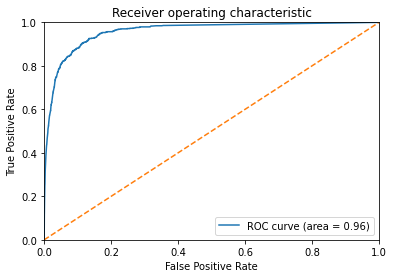

In [460]:
feature = test_df_reduced_with_metadata['sample_collection_site'].unique()
my_df = pd.DataFrame(feature)
my_df.columns = ['sample_collection_site']
auroc_by_sample_collection_site = get_scores('sample_collection_site')
auroc_by_sample_collection_site.sort_values(by="auroc", ascending=False)

In [461]:
auroc_by_sample_collection_site.sort_values(by="auprc", ascending=False).drop("auroc", axis = 1)

,auprc,negative_examples,positive_examples,train_negative,train_positive,train_cl_count,train_drug_count,test_cl_count,test_drug_count
sample_collection_site,,,,,,,,,
Embryonal,1.000000,73,2,314,7,1,321,1,75
prostate,0.866667,161,3,615,13,2,380,2,148
ovary,0.746735,1363,15,5306,48,17,396,17,382
thyroid,0.651111,677,6,2458,27,8,396,8,344
pericardial_effusion,0.633333,148,3,634,7,2,386,2,141
urinary_tract,0.622227,1314,21,5349,48,17,396,17,388
abdomen,0.566667,404,3,1563,10,5,396,5,267
kidney,0.544963,1184,12,4709,35,15,396,15,382
skin,0.515584,1946,39,7795,120,25,396,25,396


Overall AUROC: 0.9578
Overall AUPRC: 0.4279
Overall AP50: 0.7798

Average performance over 29 primary_disease :
       median    mean     std     sem     min  max
auroc  0.9620  0.9601  0.0220  0.0042  0.8955  1.0
auprc  0.4387  0.4487  0.1955  0.0369  0.1250  1.0
ap50   0.3929  0.4073  0.2179  0.0405  0.0000  1.0


,auroc,auprc,negative_examples,positive_examples,train_negative,train_positive,train_cl_count,train_drug_count,test_cl_count,test_drug_count
primary_disease,,,,,,,,,,
Unknown,1.000000,1.000000,69,1,320,6,1,326,1,70
Prostate Cancer,0.991573,0.754167,356,4,1596,24,5,396,5,248
Rhabdoid,0.986957,0.679167,230,5,932,21,3,393,3,189
Ovarian Cancer,0.982405,0.567846,2659,21,10693,91,34,396,34,395
Thyroid Cancer,0.981702,0.616439,892,14,3401,49,11,396,11,373
Myeloma,0.981593,0.596368,1169,28,4627,116,15,396,15,380
Lung Cancer,0.975485,0.368557,10914,77,43723,330,139,396,139,396
Head and Neck Cancer,0.973687,0.297544,1750,21,6860,81,22,396,22,394
Colon/Colorectal Cancer,0.971361,0.219512,3479,22,13463,64,43,396,43,396


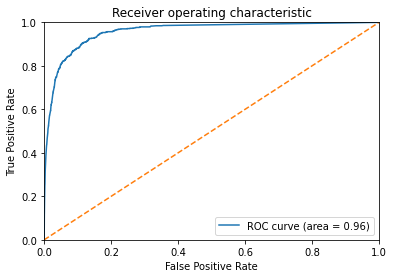

In [462]:
feature = test_df_reduced_with_metadata['primary_disease'].unique()
my_df = pd.DataFrame(feature)
my_df.columns = ['primary_disease']
auroc_by_primary_disease = get_scores('primary_disease')
auroc_by_primary_disease.sort_values(by="auroc", ascending=False)

In [448]:
pd.set_option("display.precision", 6)
auroc_by_primary_disease.sort_values(by="auprc", ascending=False).drop("auroc", axis = 1)

,auprc,negative_examples,positive_examples,train_negative,train_positive,train_cl_count,train_drug_count
primary_disease,,,,,,,
Unknown,1.000000,69,1,320,6,1,326
Prostate Cancer,0.754167,356,4,1596,24,5,396
Rhabdoid,0.679167,230,5,932,21,3,393
Bladder Cancer,0.622227,1314,21,5349,48,17,396
Thyroid Cancer,0.616439,892,14,3401,49,11,396
Myeloma,0.596368,1169,28,4627,116,15,396
Liver Cancer,0.582971,1169,25,4699,47,15,396
Ovarian Cancer,0.567846,2659,21,10693,91,34,396
Skin Cancer,0.559532,2763,46,11290,157,36,396


In [463]:
auroc_by_primary_disease["auprc"] = auroc_by_primary_disease["auprc"].round(4)

In [464]:
auroc_by_primary_disease.sort_values(by="auprc", ascending=False).drop("auroc", axis = 1).head(10)

,auprc,negative_examples,positive_examples,train_negative,train_positive,train_cl_count,train_drug_count,test_cl_count,test_drug_count
primary_disease,,,,,,,,,
Unknown,1.0000,69,1,320,6,1,326,1,70
Prostate Cancer,0.7542,356,4,1596,24,5,396,5,248
Rhabdoid,0.6792,230,5,932,21,3,393,3,189
Bladder Cancer,0.6222,1314,21,5349,48,17,396,17,388
Thyroid Cancer,0.6164,892,14,3401,49,11,396,11,373
Myeloma,0.5964,1169,28,4627,116,15,396,15,380
Liver Cancer,0.5830,1169,25,4699,47,15,396,15,379
Ovarian Cancer,0.5678,2659,21,10693,91,34,396,34,395
Skin Cancer,0.5595,2763,46,11290,157,36,396,36,396


In [465]:
auroc_by_primary_disease.sort_values(by="auprc", ascending=False).drop("auroc", axis = 1).tail(10)

,auprc,negative_examples,positive_examples,train_negative,train_positive,train_cl_count,train_drug_count,test_cl_count,test_drug_count
primary_disease,,,,,,,,,
Neuroblastoma,0.3419,1158,19,5092,67,16,396,16,386
Sarcoma,0.3000,996,14,3680,62,12,396,12,370
Head and Neck Cancer,0.2975,1750,21,6860,81,22,396,22,394
Cervical Cancer,0.2772,878,8,3423,47,11,396,11,364
Gastric Cancer,0.2509,1805,16,7198,89,23,396,23,393
Colon/Colorectal Cancer,0.2195,3479,22,13463,64,43,396,43,396
Endometrial/Uterine Cancer,0.2133,1069,12,4404,59,14,396,14,380
Bile Duct Cancer,0.1429,145,1,643,3,2,380,2,130
Adrenal Cancer,0.1250,67,1,325,3,1,328,1,68


In [452]:
auroc_by_primary_disease.sort_values(by="auprc", ascending=False).drop("auroc", axis = 1).to_csv("../../datasets/NCMF/CellLine/auprc_rf_scores.csv")

Overall AUROC: 0.958
Overall AUPRC: 0.428
Overall AP50: 0.78

Average performance over 2 sex :
       median   mean    std    sem    min    max
auroc   0.957  0.957  0.010  0.007  0.950  0.963
auprc   0.428  0.428  0.021  0.015  0.413  0.443
ap50    0.645  0.645  0.001  0.001  0.644  0.646


,auroc,auprc,ap50,negative_examples,positive_examples
sex,,,,,
Male,0.963412,0.442955,0.643972,28928,442
Female,0.949834,0.413441,0.645761,24062,317


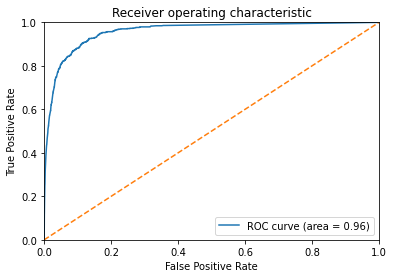

In [387]:
feature = test_df_reduced_with_metadata['sex'].unique()
my_df = pd.DataFrame(feature)
my_df.columns = ['sex']
auroc_by_gender = get_scores('sex')
auroc_by_gender.sort_values(by="auroc", ascending=False)

Overall AUROC: 0.958
Overall AUPRC: 0.428
Overall AP50: 0.78

Average performance over 2 primary_or_metastasis :
       median   mean    std    sem    min    max
auroc   0.959  0.959  0.011  0.008  0.952  0.967
auprc   0.431  0.431  0.008  0.006  0.425  0.437
ap50    0.643  0.643  0.166  0.117  0.525  0.760


,auroc,auprc,ap50,negative_examples,positive_examples
primary_or_metastasis,,,,,
Metastasis,0.967143,0.424650,0.525177,18933,202
Primary,0.951647,0.436512,0.760170,27767,389


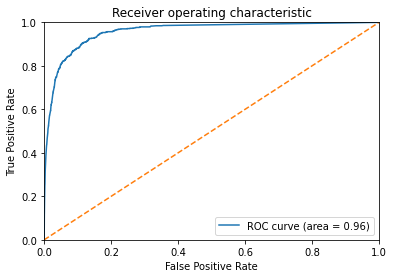

In [388]:
feature = test_df_reduced_with_metadata['primary_or_metastasis'].unique()
my_df = pd.DataFrame(feature)
my_df.columns = ['primary_or_metastasis']
auroc_by_primary_or_metastasis = get_scores('primary_or_metastasis')
auroc_by_primary_or_metastasis.sort_values(by="auroc", ascending=False)